1. load data
2. Remove distractors
3. General Analysis of the clean data
4. Split data into dev and test
5. Save metadata
6. Persist the data with DVC


# 1.load data

In [19]:
import sys
#import ipyplot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("../src/")
from utils import *

# path to the cleaned data
clean_data_path = './data/FHI2020_analysis/cleaned_data.csv'

# load data
data = pd.read_csv(clean_data_path)

# 2.Remove distractors

In [20]:
distractors = ['lactose', 'calcium-carbonate', 'starch-(maize)', 'ascorbic-acid']

print(f"Total of images before {len(data)}")

data = data.loc[~data.sample_name.isin(distractors)]
data.reset_index(drop=True, inplace=True)

print(f"Total of images after {len(data)}")

Total of images before 7888
Total of images after 7644


# 3.General Analysis of the clean data

- 3.1. Analyze by Images
   - 1. List Sample Names and their corresponding number of images
   - 2. Check the distribution of the number of images by drug and quantity
   - 3. Check images by camera type
      - 1. Check the distribution of the number of images by camera 
      - 2. Check the distribution of the number of images by camera and drug
- 3.2. Analyze by Card
   - 1. List Sample Names and their corresponding number of cards
   - 2. Check the distribution of the number of cards by drug and quantity

## 3.1. Analyze by Images

In [21]:
print(f"Total of drugs: {len(data.sample_name.unique())}")

Total of drugs: 20


In [22]:
img_counter_by_drug = data.value_counts(['sample_name']).reset_index(name='counts')
img_counter_by_drug

,sample_name,counts
0,hydroxychloroquine,821
1,rifampicin,476
2,ciprofloxacin,455
3,pyrazinamide,447
4,ferrous-sulfate,438
5,azithromycin,438
6,chloroquine,438
7,ripe,427
8,ethambutol,403
9,ceftriaxone,387


In [23]:
# list of drugs name sorted by the number of images
drugs = img_counter_by_drug.sample_name.to_list()

### Check the distribution of the number of images by drug and quantity

In [24]:
# plot the distribution of the number of images per drug
img_counter_by_drug_quantity = data[['sample_name', 'quantity']].value_counts().reset_index(name='counts')
img_counter_by_drug_quantity.sort_values(by=['sample_name', 'quantity'], inplace=True)
img_counter_by_drug_quantity

,sample_name,quantity,counts
70,albendazole,20,51
69,albendazole,50,53
66,albendazole,80,59
10,albendazole,100,118
12,amoxicillin,20,116
...,...,...,...
52,sulfamethoxazole,100,88
55,tetracycline,20,84
42,tetracycline,50,99
44,tetracycline,80,93


### Check the distribution of the number of images for a specific drug

In [25]:
drug = 'benzyl-penicillin'
img_counter_by_drug_quantity[img_counter_by_drug_quantity['sample_name']==drug]

,sample_name,quantity,counts
77,benzyl-penicillin,20,29
79,benzyl-penicillin,50,12
76,benzyl-penicillin,80,31
78,benzyl-penicillin,100,22


<Axes: xlabel='quantity', ylabel='sample_name'>

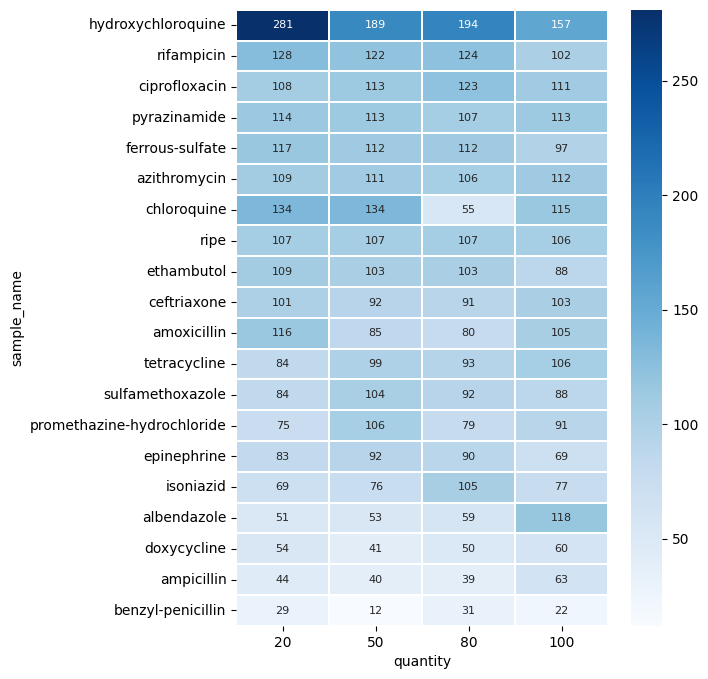

In [26]:
img_counter_by_drug_quantity = img_counter_by_drug_quantity.copy()
img_counter_by_drug_quantity['sample_name'] = pd.Categorical(img_counter_by_drug_quantity['sample_name'], drugs)

table = img_counter_by_drug_quantity.pivot(index="sample_name", columns="quantity", values="counts")
fig, ax = plt.subplots(figsize=(6, 8))
sns.heatmap(table, annot=True, annot_kws={"size": 8}, fmt='g', cmap='Blues', linewidths=.3)

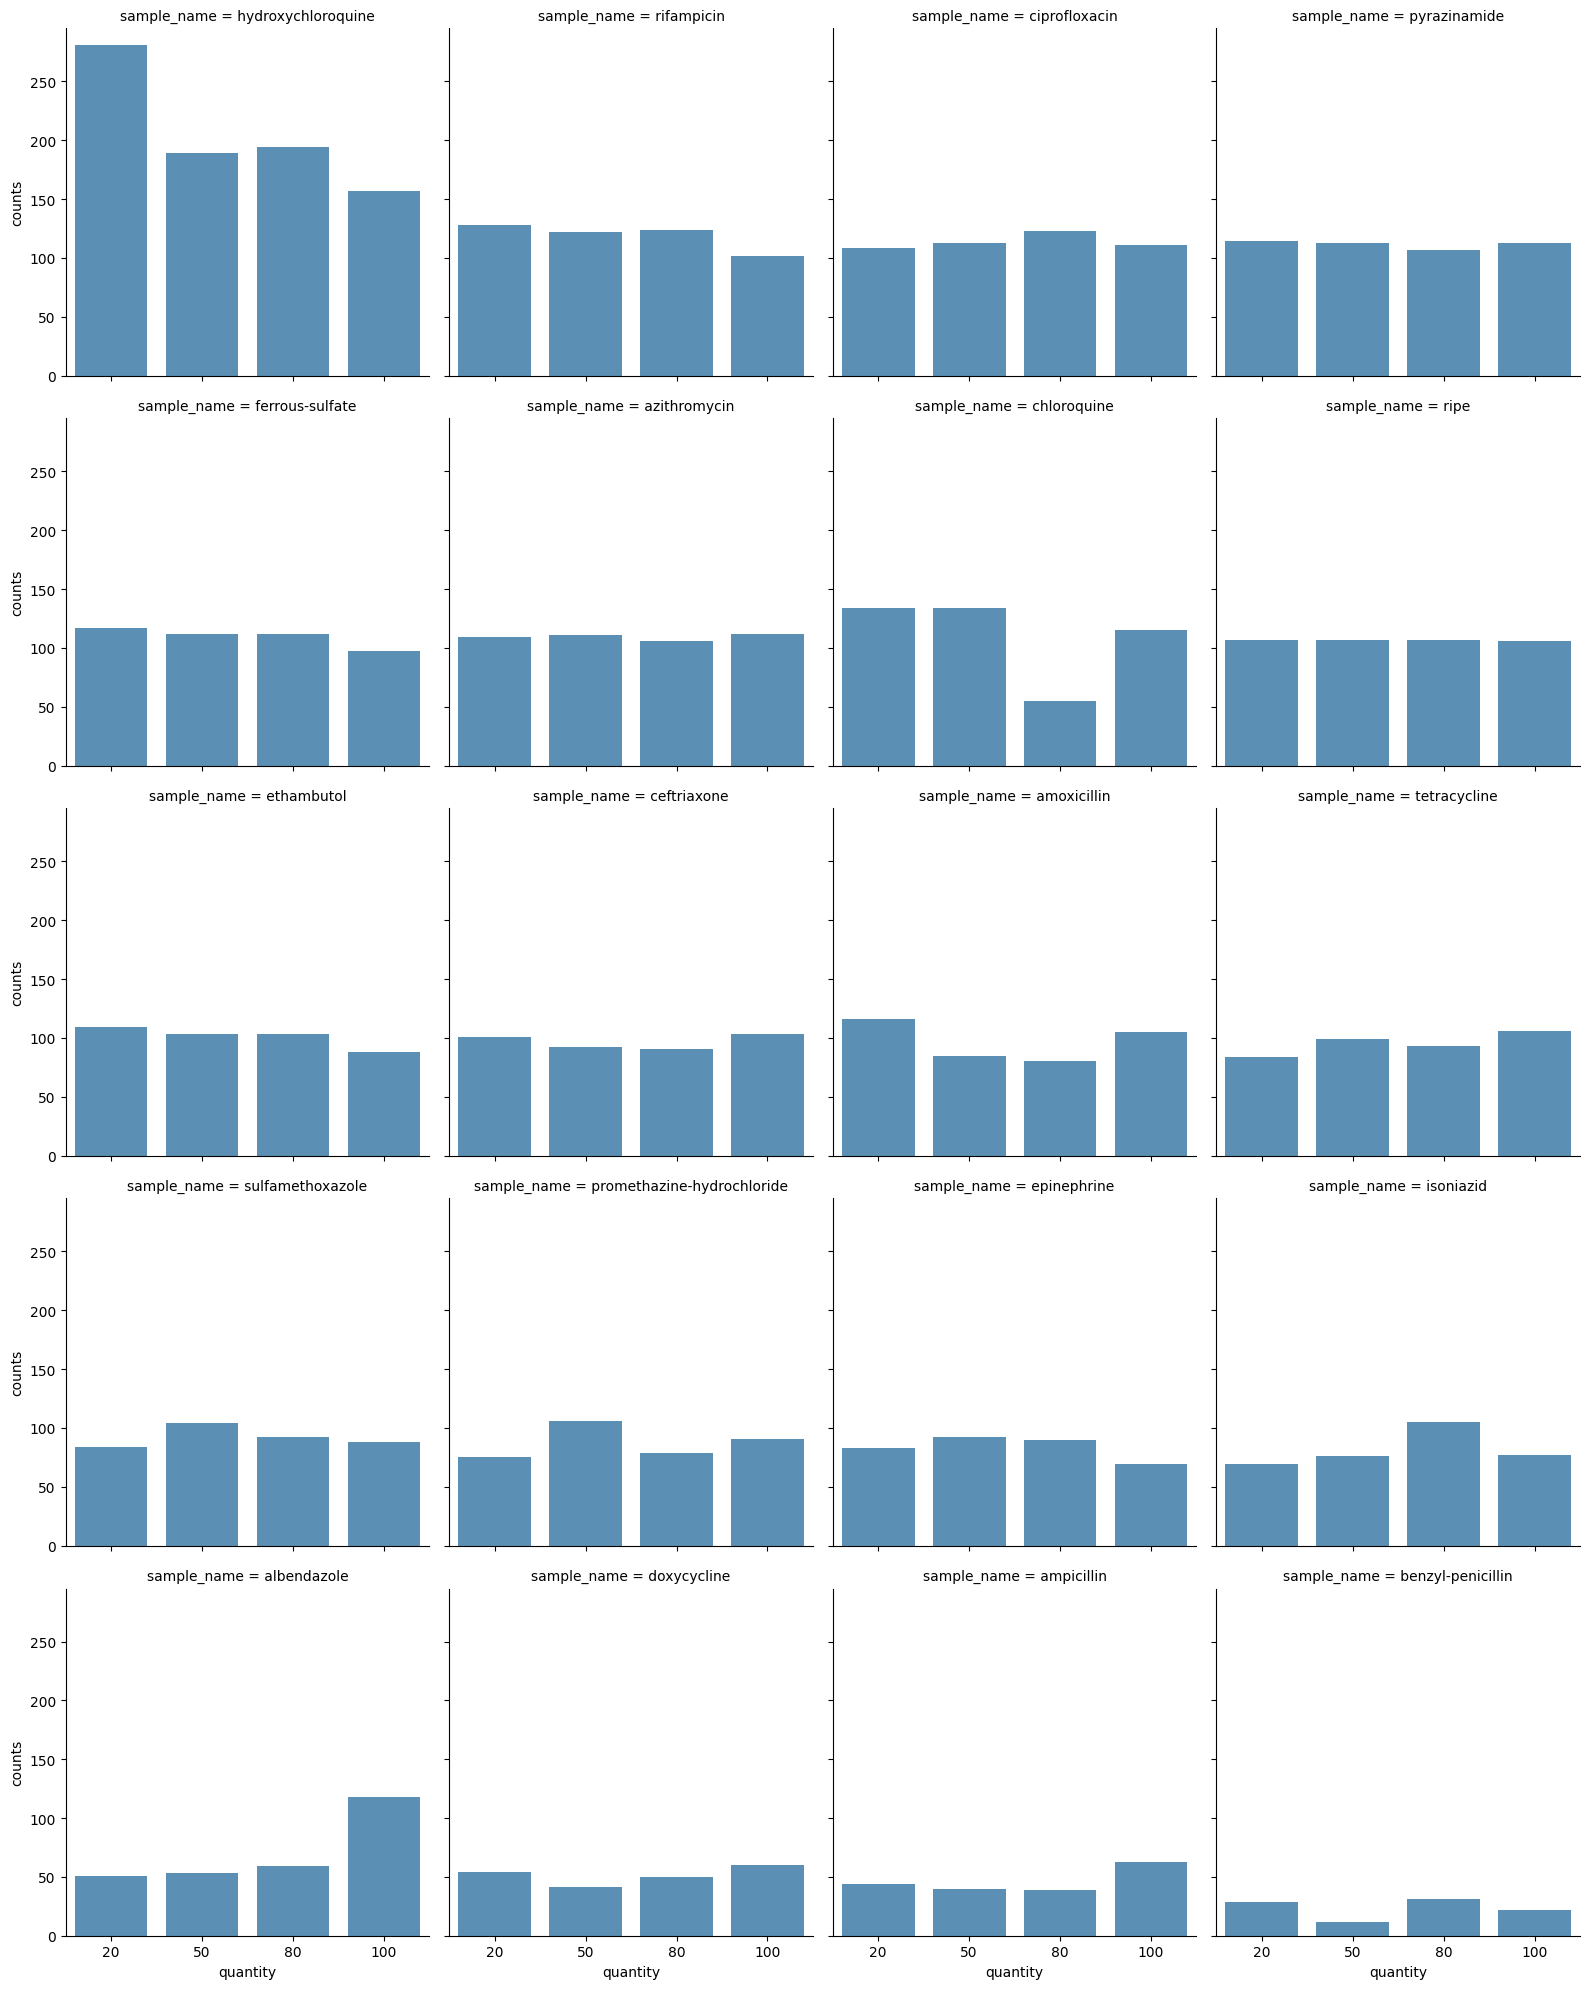

In [27]:
quantities = img_counter_by_drug_quantity.quantity.unique()
g = sns.FacetGrid(img_counter_by_drug_quantity, col="sample_name", col_wrap=4, height=4)
g.map(sns.barplot, 'quantity', "counts",  order=quantities, alpha=0.8)

#### Check images by camera type

In [28]:
data[['sample_id','sample_name','quantity', 'camera_type_1']].value_counts().reset_index(name='counts')

,sample_id,sample_name,quantity,camera_type_1,counts
0,53000,hydroxychloroquine,20,Galaxy S9,23
1,51730,hydroxychloroquine,20,Galaxy S9,19
2,53006,hydroxychloroquine,20,Galaxy S9,18
3,51727,hydroxychloroquine,20,Galaxy S9,17
4,53004,hydroxychloroquine,20,Galaxy S9,13
...,...,...,...,...,...
3923,53464,hydroxychloroquine,80,iPhone 11,1
3924,53464,hydroxychloroquine,80,Google Pixel 3a,1
3925,53462,amoxicillin,20,Galaxy S9,1
3926,53462,amoxicillin,20,BLU BLU R1 HD,1


#### Check the distribution of the number of images by camera 

In [29]:
img_counter_by_camera = data[['camera_type_1']].value_counts().reset_index(name='counts')
img_counter_by_camera

,camera_type_1,counts
0,samsung SM-A505F,3091
1,HMD Global Nokia 2.3,1792
2,Google Pixel 3a,1209
3,Galaxy S9,771
4,Heather Iphone XS,302
5,iPhone 11,201
6,Kat Galaxy S9,110
7,BLU BLU R1 HD,108
8,Jessica Galaxy,56
9,samsung SM-G770U1,4


<Axes: xlabel='counts', ylabel='camera_type_1'>

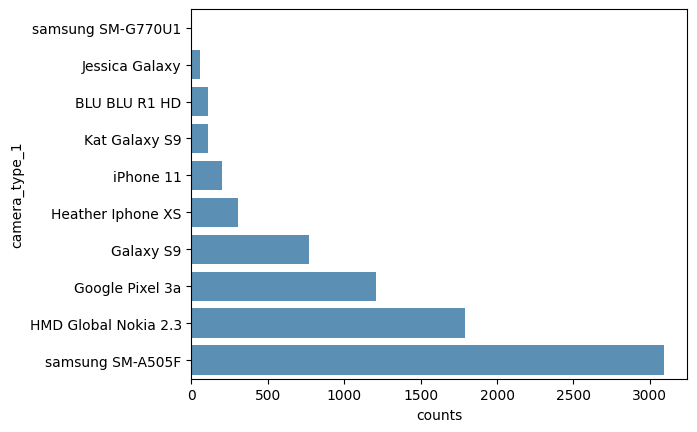

In [30]:
# Total of samples by drug
sns.barplot(img_counter_by_camera.sort_values(by=['counts']), x='counts', y="camera_type_1", orient="y", alpha=0.8)

#### Check the distribution of the number of images by camera and drug

<Axes: xlabel='sample_name', ylabel='camera_type_1'>

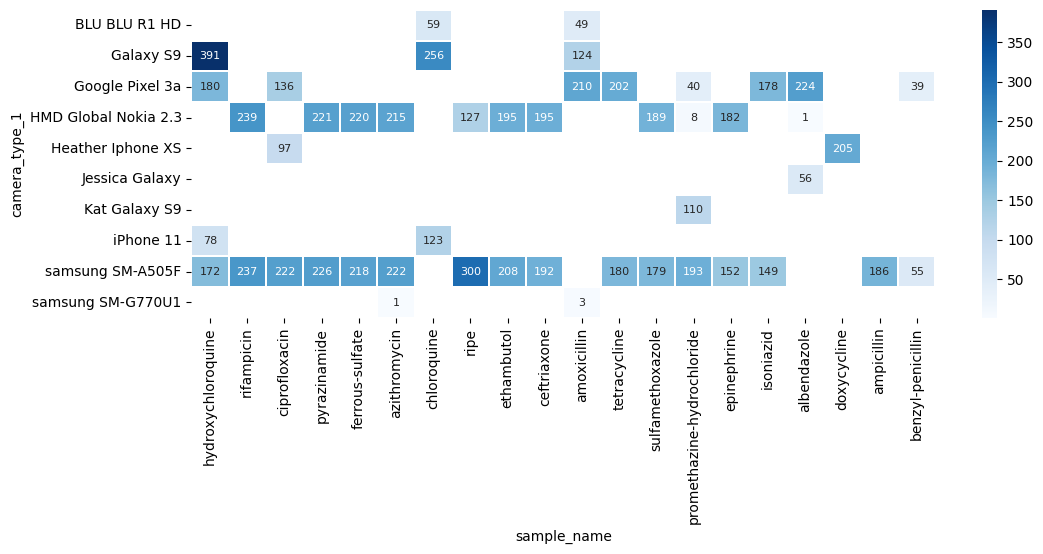

In [31]:
camera_quantity_counter = data[['camera_type_1', 'sample_name']].value_counts().reset_index(name='counts')
camera_quantity_counter_cat_rev = camera_quantity_counter.copy()
camera_quantity_counter_cat_rev['sample_name'] = pd.Categorical(camera_quantity_counter['sample_name'], drugs)

# plot heatmap
table = camera_quantity_counter_cat_rev.pivot(index="camera_type_1", columns="sample_name", values="counts")
fig, ax = plt.subplots(figsize=(12, 4))
sns.heatmap(table, annot=True, annot_kws={"size": 8}, fmt='g', cmap='Blues', linewidths=.3)


## 3.2. Analyze by Card

### Single samples

Here, I am disregarding whether the same PAD was photographed several times.

#### total of unique samples per `sample_name` (class/category)

In [39]:
samples_unique = data[['sample_id','sample_name']].value_counts().reset_index(name='counts')
print(f"Total of Unique samples {samples_unique.shape[0]}")

samples_unique_grp = samples_unique.groupby(['sample_name']).size().reset_index(name='counts')
unique_class_counter = samples_unique_grp.sort_values(by=['counts'], ascending=False).reset_index(drop=True)
print(f"{unique_class_counter['sample_name'].to_list()}")

Total of Unique samples 2144
['rifampicin', 'sulfamethoxazole', 'ciprofloxacin', 'doxycycline', 'chloroquine', 'azithromycin', 'ferrous-sulfate', 'isoniazid', 'pyrazinamide', 'amoxicillin', 'albendazole', 'ceftriaxone', 'ampicillin', 'ripe', 'hydroxychloroquine', 'ethambutol', 'tetracycline', 'promethazine-hydrochloride', 'epinephrine', 'benzyl-penicillin']


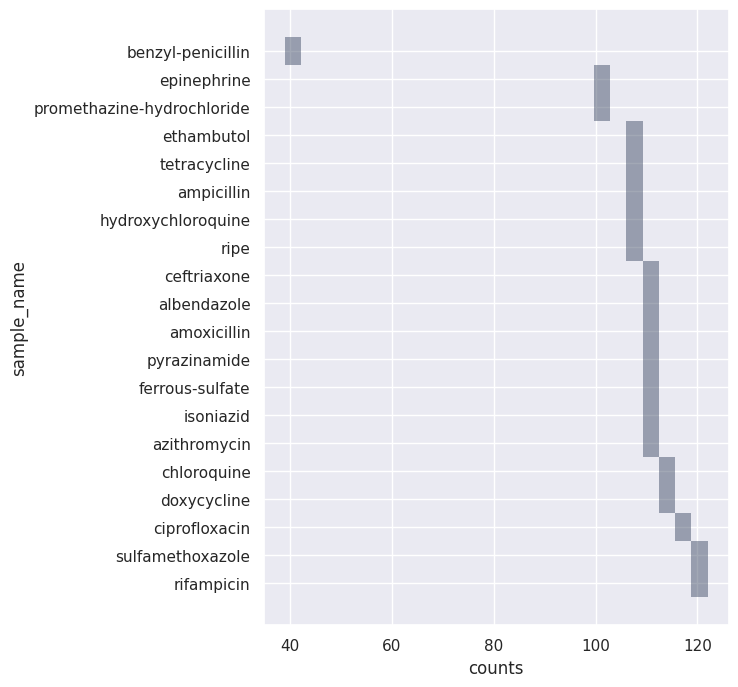

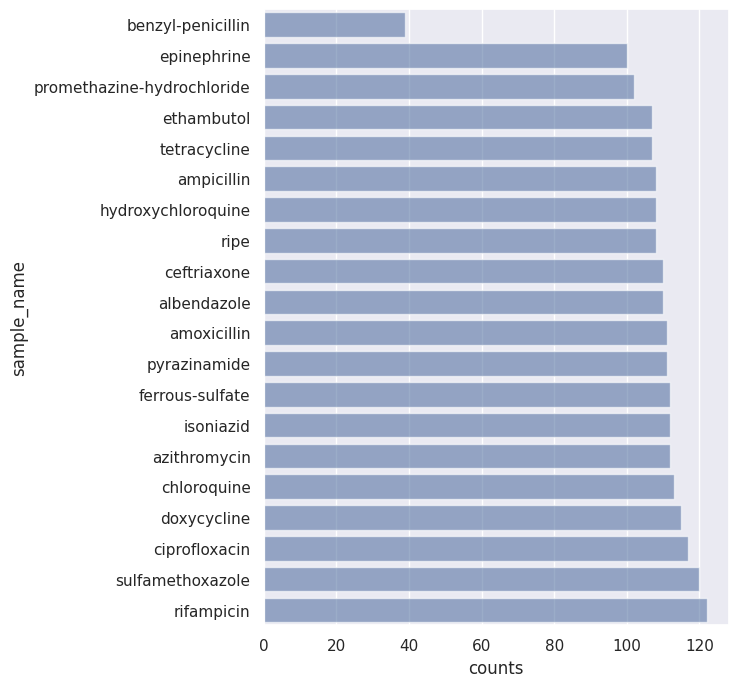

In [40]:
# libraries & dataset
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(figsize=(6, 8))
sns.histplot(data=samples_unique_grp.sort_values(by=['counts']), x="counts",  y="sample_name",  alpha=0.5, linewidths=.8)
plt.show()

fig, ax = plt.subplots(figsize=(6, 8))
sns.barplot(samples_unique_grp.sort_values(by=['counts']), x='counts', y="sample_name", orient="y", alpha=0.6)
plt.show()

In [41]:
samples_unique = data[['sample_id','sample_name','quantity']].value_counts().reset_index(name='counts')

In [42]:
df1 = samples_unique[['sample_name','quantity']].value_counts().reset_index(name='counts')
df1

,sample_name,quantity,counts
0,sulfamethoxazole,50,38
1,ampicillin,100,37
2,chloroquine,100,32
3,albendazole,100,32
4,rifampicin,80,32
...,...,...,...
75,ampicillin,50,22
76,benzyl-penicillin,20,12
77,benzyl-penicillin,80,11
78,benzyl-penicillin,100,10


In [43]:
df2 = data[['sample_name','quantity']].value_counts().reset_index(name='counts')
df2

,sample_name,quantity,counts
0,hydroxychloroquine,20,281
1,hydroxychloroquine,80,194
2,hydroxychloroquine,50,189
3,hydroxychloroquine,100,157
4,chloroquine,20,134
...,...,...,...
75,ampicillin,80,39
76,benzyl-penicillin,80,31
77,benzyl-penicillin,20,29
78,benzyl-penicillin,100,22


In [44]:
df1.loc[df1.sample_name == 'hydroxychloroquine']

,sample_name,quantity,counts
36,hydroxychloroquine,50,27
37,hydroxychloroquine,100,27
48,hydroxychloroquine,80,27
50,hydroxychloroquine,20,27


In [45]:
df2.loc[df2.sample_name == 'hydroxychloroquine']

,sample_name,quantity,counts
0,hydroxychloroquine,20,281
1,hydroxychloroquine,80,194
2,hydroxychloroquine,50,189
3,hydroxychloroquine,100,157


NOTE: *`df1`* gives counts by **unique sample_id** and *`df2`* gives counts considering  **duplicated sample_id** (the total of picutures) 

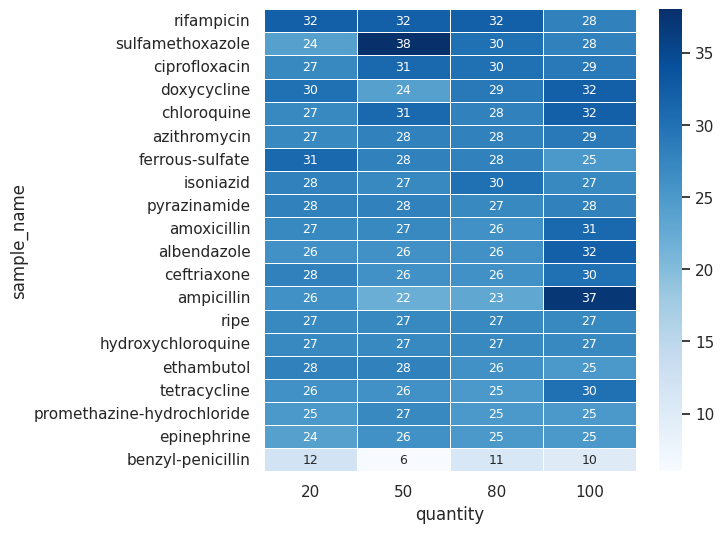

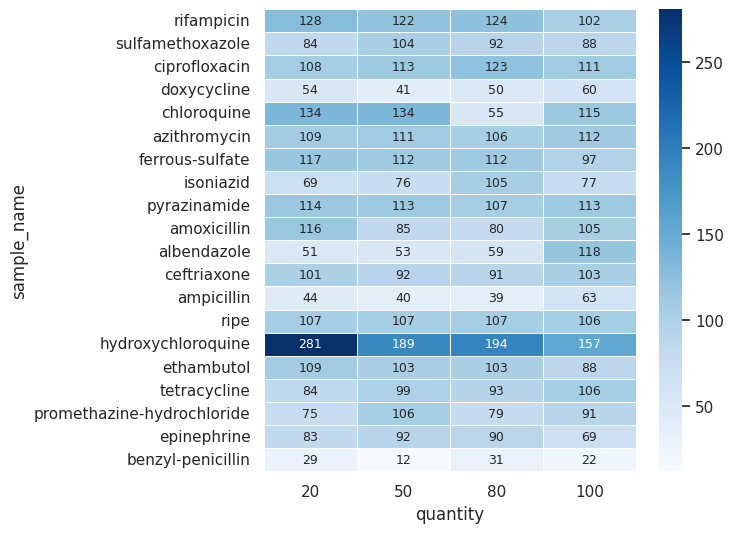

In [46]:
rows = "sample_name"
cols = "quantity"
values = "counts"
rows_order = unique_class_counter['sample_name'].to_list()

show_heatmap(df1, rows, cols, values, rows_order)
show_heatmap(df2, rows, cols, values, rows_order)

## Split the dataset in development and test sets


Note: I removed the samples that are disctractors from the dataset.

In [47]:
def show_heatmap_tables(table1, table2, save_name=None, figsize=(18, 8),
                        caption="Your main caption here", title1="Table 1", title2="Table 2", cmap='Blues'):
    plt.rcParams["figure.autolayout"] = True
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    sns.heatmap(table1, annot=True, annot_kws={"size": 9}, fmt='g', cmap=cmap, linewidths=.4, ax=axes[0])
    axes[0].set_title(title1)  # Title for the first heatmap

    sns.heatmap(table2, annot=True, annot_kws={"size": 9}, fmt='g', cmap=cmap, linewidths=.4, ax=axes[1])
    axes[1].set_title(title2)  # Title for the second heatmap

    plt.suptitle(caption)  # Main caption/title for the figure

    plt.show()
    
    if save_name: 
        fig.savefig(save_name, bbox_inches='tight')

In [48]:
# remove distractores
distractors = ['lactose', 'calcium-carbonate', 'starch-(maize)', 'ascorbic-acid']
data = data.loc[~data.sample_name.isin(distractors)]
data.reset_index(drop=True, inplace=True)

print(f"Total of images {len(data)}")

Total of images 7644


data before splitting

In [49]:

def show_heatmap(df, rows, cols, values, rows_order = None, save_name= None, figsize=(6, 6)):
    import pandas as pd 
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    df_cat = df.copy()
    df_cat[rows] = pd.Categorical(df[rows], rows_order)
    table = df_cat.pivot(index=rows, columns=cols, values=values)
    
    fig, _ = plt.subplots(figsize=figsize)
    sns.heatmap(table, annot=True, annot_kws={"size": 9}, fmt='g', cmap='Blues', linewidths=.4)
    plt.show()
    if save_name: fig.savefig(save_name,bbox_inches='tight') 

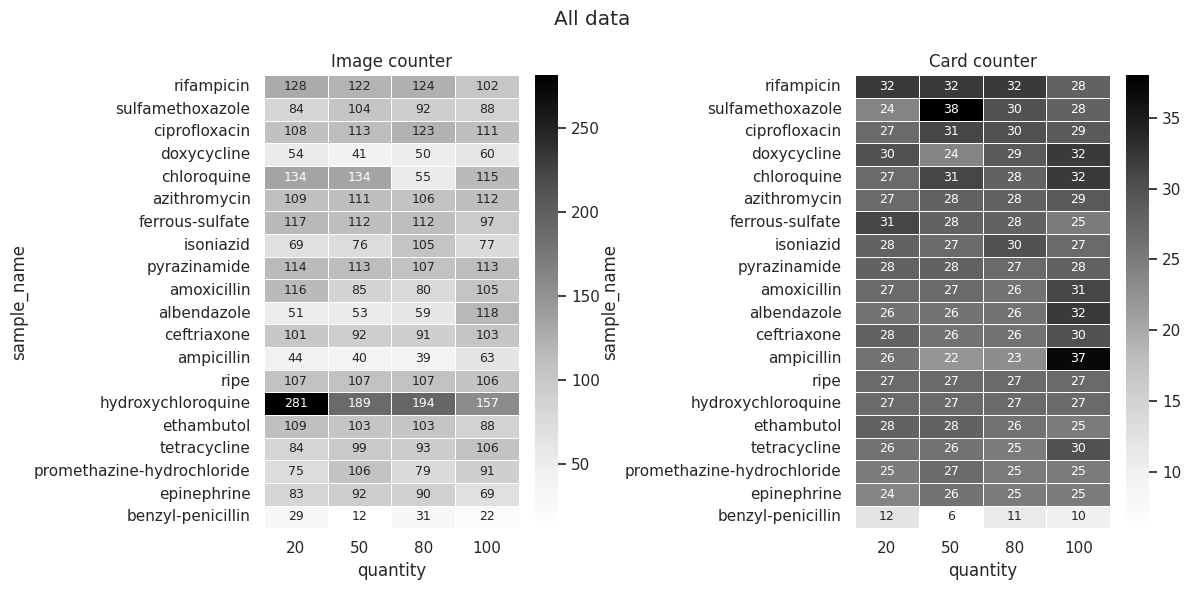

In [50]:
set_df = data
samples_unique = set_df[['sample_id','sample_name','quantity']].value_counts().reset_index(name='counts')
df1 = samples_unique[['sample_name','quantity']].value_counts().reset_index(name='counts')
df2 = set_df[['sample_name','quantity']].value_counts().reset_index(name='counts')

rows = "sample_name"
cols = "quantity"
values = "counts"
caption = f"All data"
title1="Image counter" 
title2="Card counter" 
cmap = "Greys"
rows_order = unique_class_counter['sample_name'].to_list()

table1 = get_heatmap_table(df1, rows, cols, values, rows_order)
table2 = get_heatmap_table(df2, rows, cols, values, rows_order)
show_heatmap_tables(table2, table1, save_name= f"../datasets/FHI2020_Stratified_Sampling/report/all_data.png", 
                    figsize=(12, 6), caption=caption, title1=title1, title2=title2, cmap=cmap) 

In [51]:
sample_names = data.sample_name.unique()
quantities = data.quantity.unique()

In [52]:
splits = [{'test_size': 0.10, 'cmap': "RdPu"},
          {'test_size': 0.15, 'cmap': "Purples"}, 
          {'test_size': 0.20, 'cmap': "Blues"}, 
          {'test_size': 0.25, 'cmap': "YlOrBr"},
          {'test_size': 0.30, 'cmap': "YlGn"},]

split_id=3


In [53]:
from sklearn.model_selection import GroupShuffleSplit

# Parameters of the splitting 
random_state = 42
test_size = splits[split_id]['test_size']
dev_size = 1 - test_size

# Parameters of the plots
cmap=splits[split_id]['cmap']
title1="Image counter" 
title2="Card counter" 
str_split = f" [Dev {int(dev_size*100)}% | Test {int(test_size*100)}%]" 

# Initialize the splitter
splitter = GroupShuffleSplit(test_size=test_size, n_splits=1, random_state=random_state)

# I'll split based on 'sample_id' to ensure images of the same card stay together
# Assuming 'group' here would represent the combined 'sample_name' and 'quantity' for stratification
all_train_idx = []
all_test_idx = []
for sample_name in sample_names:
    for quantity in quantities:
        #print(f"\n{sample_name}\t{quantity}")
        subset = data[(data['sample_name'] == sample_name) & (data['quantity'] == quantity)]
        
        # Perform the split
        for train_idx, test_idx in splitter.split(subset, groups=subset['sample_id']):
            train_subset = subset.iloc[train_idx]
            test_subset = subset.iloc[test_idx]

            # append these subsets to the overall training and testing set indexes
            all_train_idx += train_subset.index.tolist()
            all_test_idx += test_subset.index.tolist()
            #print(f"train {len(train_idx)} test {len(test_idx)}")
            
test_df = data.iloc[all_test_idx].copy()
train_val_df = data.iloc[all_train_idx].copy()

In [54]:
len(test_df), len(train_val_df), len(test_df) + len(train_val_df)

(1966, 5678, 7644)

#### `test_df`

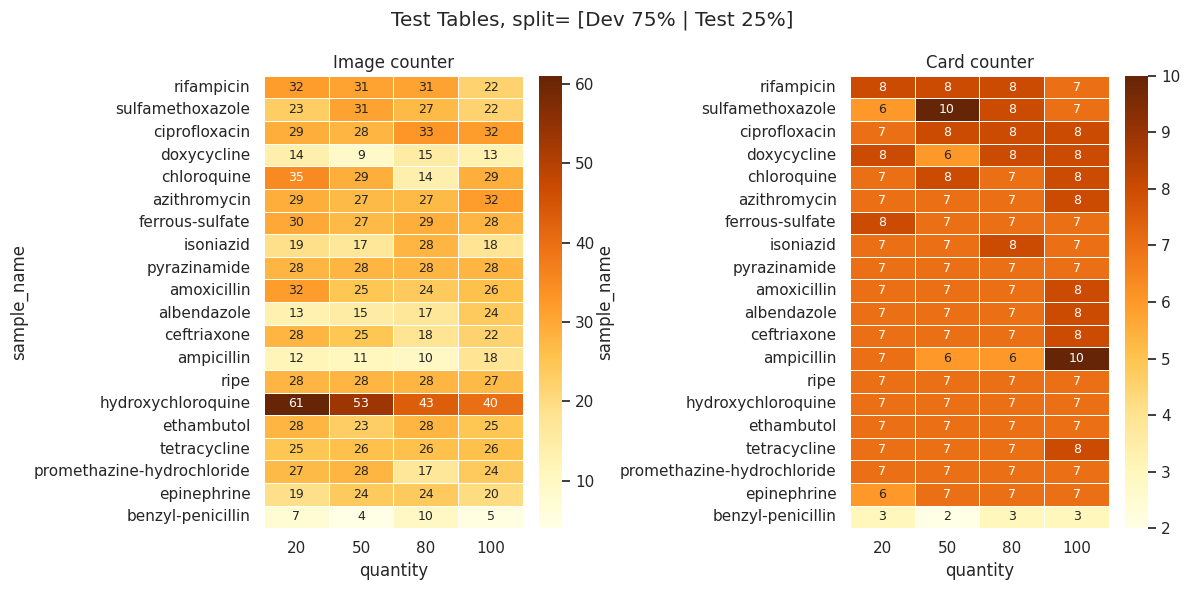

In [55]:
set_df = test_df
samples_unique = set_df[['sample_id','sample_name','quantity']].value_counts().reset_index(name='counts')
df1 = samples_unique[['sample_name','quantity']].value_counts().reset_index(name='counts')
df2 = set_df[['sample_name','quantity']].value_counts().reset_index(name='counts')

rows = "sample_name"
cols = "quantity"
values = "counts"
caption = f"Test Tables, split={str_split}"
rows_order = unique_class_counter['sample_name'].to_list()

table1 = get_heatmap_table(df1, rows, cols, values, rows_order)
table2 = get_heatmap_table(df2, rows, cols, values, rows_order)
show_heatmap_tables(table2, table1, save_name= f"../datasets/FHI2020_Stratified_Sampling/report/test__tsize_{str(int(test_size*100))}.png", 
                    figsize=(12, 6), caption=caption, title1=title1, title2=title2, cmap=cmap) 
                    

#### `train_val_df`

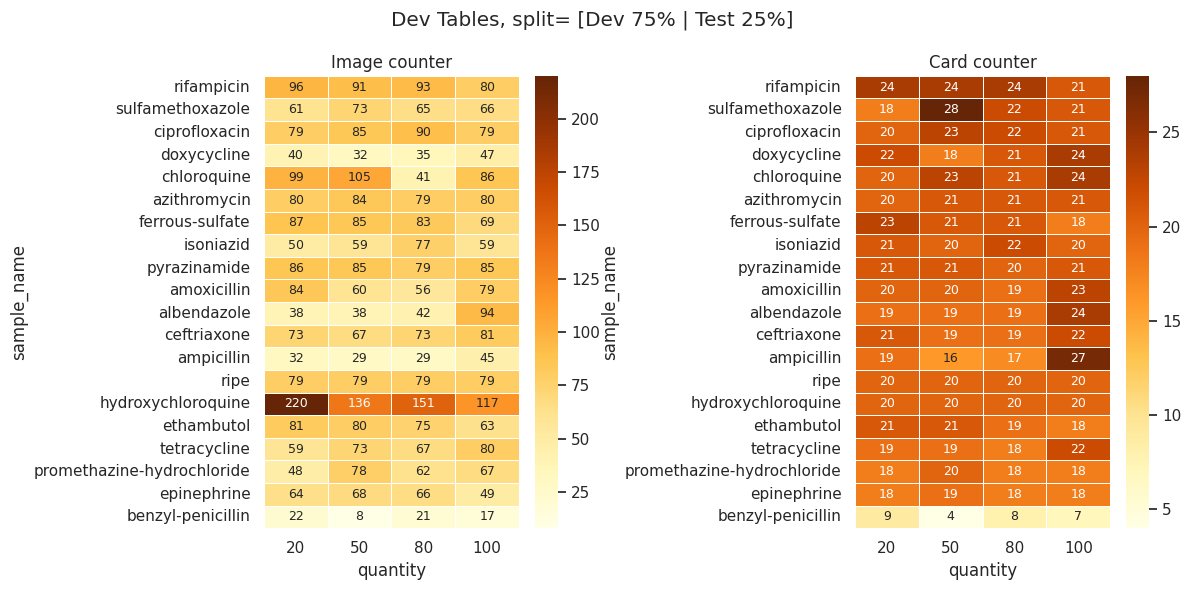

In [56]:
set_df = train_val_df
samples_unique = set_df[['sample_id','sample_name','quantity']].value_counts().reset_index(name='counts')
df1 = samples_unique[['sample_name','quantity']].value_counts().reset_index(name='counts')
df2 = set_df[['sample_name','quantity']].value_counts().reset_index(name='counts')

rows = "sample_name"
cols = "quantity"
values = "counts"
caption = f"Dev Tables, split={str_split}"
rows_order = unique_class_counter['sample_name'].to_list()

table1 = get_heatmap_table(df1, rows, cols, values, rows_order)
table2 = get_heatmap_table(df2, rows, cols, values, rows_order)
show_heatmap_tables(table2, table1, save_name= f"../datasets/FHI2020_Stratified_Sampling/report/dev__tsize_{str(int(test_size*100))}.png",
                    figsize=(12, 6), caption=caption, title1=title1, title2=title2, cmap=cmap) 

# show heatmap separately
#show_heatmap(df1, rows, cols, values, rows_order)


#### Camera type distribution

<Axes: xlabel='counts', ylabel='camera_type_1'>

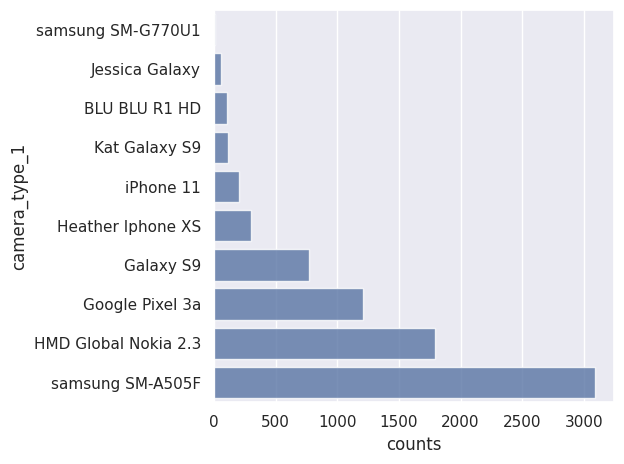

In [57]:
camera_counter = data[['camera_type_1']].value_counts().reset_index(name='counts')
camera_counter.sort_values(by=['counts'], inplace=True)
camera_counter

# Total of samples by camera type
sns.barplot(camera_counter, x='counts', y="camera_type_1", orient="y", alpha=0.8)

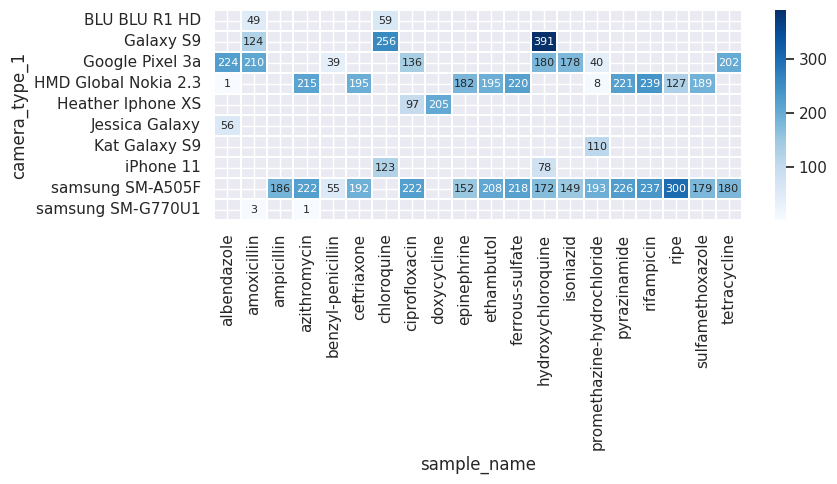

In [58]:
camera_quantity_counter = data[['camera_type_1', 'sample_name']].value_counts().reset_index(name='counts')
camera_quantity_counter_cat_rev = camera_quantity_counter.copy()
camera_quantity_counter_cat_rev['sample_name'] = pd.Categorical(camera_quantity_counter['sample_name']) #, sample_name_list[::-1])

# plot heatmap
table = camera_quantity_counter_cat_rev.pivot(index="camera_type_1", columns="sample_name", values="counts")
fig, ax = plt.subplots(figsize=(9, 5))
sns.heatmap(table, annot=True, annot_kws={"size": 8}, fmt='g', cmap='Blues', linewidths=.3)

fig.savefig("../datasets/FHI2020_Stratified_Sampling/report/camera_drug_heatmap.png", bbox_inches='tight') 

#### check if the sets don't have intersections in terms of sample_id

In [59]:
# Size of sets considering all images
print(f"# Size of sets considering all images")
print(f" - train_val: {len(train_val_df)}")
print(f" - test: {len(test_df)}")
print(f" - total: {len(data)}")
print()

# Size of sets considering unique sample_ids
print(f"# Size of sets considering unique sample_ids")
print(f" - train_val: {len(train_val_df.groupby(['sample_id']))}")
print(f" - test: {len(test_df.groupby(['sample_id']))}")
print(f" - total: {len(data.groupby(['sample_id']))}")
print()

# Size of sets considering all images
 - train_val: 5678
 - test: 1966
 - total: 7644

# Size of sets considering unique sample_ids
 - train_val: 1588
 - test: 563
 - total: 2144



In [60]:
ids_test = test_df.loc[(test_df.sample_name == 'benzyl-penicillin') & (test_df.quantity == 20), 'sample_id']
ids_trainval = train_val_df.loc[(train_val_df.sample_name == 'benzyl-penicillin') & (train_val_df.quantity == 20), 'sample_id']

pd.Series(list(set(ids_trainval).intersection(set(ids_test))))

/tmp/ipykernel_144055/962289832.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(list(set(ids_trainval).intersection(set(ids_test))))


Series([], dtype: float64)

- Save dataframes for test and dev sets in csv files

In [61]:
# create a column for image file names in both dataframes 
test_df['image_name'] = test_df.apply(lambda x: create_filename(x), axis=1)
train_val_df['image_name'] = train_val_df.apply(lambda x: create_filename(x), axis=1)

# columns to be saved
column_name_list = ['id','sample_id', 'sample_name', 'quantity', 'camera_type_1', 'url', 'hashlib_md5', 'image_name'] 

# save to csv
test_df[column_name_list].to_csv('../datasets/FHI2020_Stratified_Sampling/test_set.csv', index=False)
train_val_df[column_name_list].to_csv('../datasets/FHI2020_Stratified_Sampling/dev_set.csv', index=False)

- 

## 5. Save metadata


- checking any left duplicates

In [64]:
_ = check_duplicates_by_hash(data)

There is no duplicates.


### Set Dataset GENRAL metadata

In [147]:
dataset_name = 'FHI2020_Stratified_Sampling'
dataset_description = """This dataset is based on data from Project FHI2020 and comprises images from PADs, each representing a specific API from a predefined list of 20 APIs and one of four possible quantities (20, 50, 80, 100). The dataset features multiple images of the same PAD, captured under varying illumination conditions and using different devices, each image uniquely identified by an image_id, while cards share a sample_id. To address the challenge posed by its unbalanced nature regarding API names and quantities, a stratified sampling approach was employed for data splitting. Specifically, the dataset was divided such that for each API, and within each quantity category of that API, 10% of the PADs(considering all their photographs) were allocated to the test set, ensuring a proportional representation across both developing and testing subsets. This method not only maintains the balance of API types and quantities but also ensures that all photographs of the same PAD are kept together, either in the developing or the test set, to prevent data leakage and promote model generalizability.There are no distractors included in this dataset."""
dev_size = 1 - test_size
random_state = 42
hash_type = 'hashlib_md5'


### Save metadata to the yaml file

In [148]:
import pandas as pd
import yaml

# Iterate through each row in the dataframe and add pad information to metadata
def add_pad_info_to_metadata(dataframe, metadata, dataset_name):
    for index, row in dataframe.iterrows():
        pad_info = {
            'id': row['id'],
            'sample_id': row['sample_id'],
            'sample_name': row['sample_name'],
            'quantity': row['quantity'],            
            'filename': create_filename(row),
            'image_hash': row[hash_type],
            'image_source': row['url']
        }
        metadata[dataset_name].append(pad_info)

metadata = {
    'name': dataset_name,
    'description': dataset_description,
    'creation':  get_iso8601_datetime(),
    'split': {  # Save information about the dataset splitting in development and test sets
        'dev_size': dev_size,        
        'random_seed': random_state
    },
    'hash_type': hash_type,
    'dev_set': [], # train_val_df
    'test_set': [] # test_df
}

# Create a path for that dataset
dataset_path = os.path.join( "../datasets/", dataset_name) 
os.makedirs(dataset_path, exist_ok=True)

# add metadata for each subset
add_pad_info_to_metadata(train_val_df, metadata, 'dev_set')
add_pad_info_to_metadata(test_df, metadata, 'test_set')

# Convert the metadata dictionary to YAML format
yaml_output = yaml.dump(metadata, sort_keys=False)

# Save the YAML data to a file
fpath = os.path.join(dataset_path, "metadata.yaml")
with open(fpath, 'w') as yaml_file:
    yaml_file.write(yaml_output)

print("Metadata file 'metadata.yaml' has been created.")


Metadata file 'metadata.yaml' has been created.


## 6. Persist the data and info with DVC


```bash
# images
!dvc add datasets/FHI2020_Stratified_Sampling/dev_images/
!dvc add datasets/FHI2020_Stratified_Sampling/test_images/
# metadata
!dvc add datasets/FHI2020_Stratified_Sampling/dev_set.csv
!dvc add datasets/FHI2020_Stratified_Sampling/test_set.csv
# report
!dvc add datasets/FHI2020_Stratified_Sampling/report/test__tsize_25.png 
!dvc add datasets/FHI2020_Stratified_Sampling/report/dev__tsize_25.png 
!dvc add datasets/FHI2020_Stratified_Sampling/report/all_data.png
!dvc add datasets/FHI2020_Stratified_Sampling/report/camera_drug_heatmap.png
```